#Introduction/Background

Current work has been detailed in GDocs but needs to be 'practialised'.

Intention for this week is to match development to Bella's Chapter 4 Analysis of Trust and a little more, encompassing:
* Demonstration of Trust Assessment from Metrics
* Exploration of Packet Emmission Rate for Standard Static Case
* Exploration of Existing Mobility Models (static, 1-mobile, allbut1-mobile, all-mobile)
* Exploration of Generalised Trust Performance across Varying Distances
* Trust Weighting across the above
* OTMF/Beta comparative Assessment of the above
* Exploration of Time-series smoothing for trust (EWMA/Retrospective Observations, etc)

This notebook should also operate as a 'test suite' 

# Required Modules and Configurations

In [15]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import quantities as q
from collections import OrderedDict
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform

import aietes
import aietes.Tools as Tools
import bounos.ChartBuilders as cb
import bounos.Analyses.Trust as Trust
import bounos.multi_loader as multi_loader

#print(matplotlib.rcParams)
_boxplot_kwargs = {
    'showmeans':True,
    'showbox':False,
    'widths':0.2,
    'linewidth':2
}

from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

import scipy.interpolate as interpolate
#pylab.rcParams['figure.figsize'] = 16, 12  

golden_mean  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
w=4
cb.latexify(columns=2, factor=0.8)

def interpolate_rate_sep(df, key):
    X,Y,Z = df.rate, df.separation, df[key]

    xi = np.linspace(X.min(),X.max(),16)
    yi = np.linspace(Y.min(),Y.max(),16)
    # VERY IMPORTANT, to tell matplotlib how is your data organized
    zi = interpolate.griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='linear')
    return xi,yi,zi, X, Y
    
def plot_contour_pair(xi,yi,zi):
    fig = plt.figure(figsize=(2*w,golden_mean*w*2))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    

    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,color='k')
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    xig, yig = np.meshgrid(xi, yi)

    surf = ax.plot_surface(xig, yig, zi,linewidth=0)
    return fig

def plot_contour_3d(xi,yi,zi, rot=120, labels=None):
    fig = plt.figure(figsize=(w,golden_mean*w))
    ax = fig.add_subplot(1,1,1, projection='3d')
    # Normalise Z
    zi_norm = zi / np.nanmax(zi)
    xig, yig = np.meshgrid(xi, yi)
    
    if rot < 90:
        zoffset=np.nanmin(zi)
        xoffset=np.nanmin(xig)
        yoffset=np.nanmin(yig)
    elif rot < 180:
        zoffset=np.nanmin(zi)
        xoffset=np.nanmax(xig)
        yoffset=np.nanmin(yig)
    else:
        zoffset=np.nanmin(zi)
        xoffset=np.nanmax(xig)
        yoffset=np.nanmax(yig)
    
    ax.plot_surface(xig, yig, zi, rstride=1, cstride=1, alpha=0.45, facecolors=cm.coolwarm(zi_norm), linewidth=1, antialiased=True)
    cset = ax.contour(xig, yig, zi, zdir='z', offset=zoffset, linestyles='dashed', cmap=cm.coolwarm)
    cset = ax.contour(xig, yig, zi, zdir='x', offset=xoffset, cmap=cm.coolwarm)
    cset = ax.contour(xig, yig, zi, zdir='y', offset=yoffset, cmap=cm.coolwarm)
    ax.view_init(30,rot)
    
    if labels is not None:
        ax.set_xlabel(labels['x'])
        ax.set_ylabel(labels['y'])
        ax.set_zlabel(labels['z'])
        
    fig.tight_layout()
    return fig

def plot_contour_2d(xi,yi,zi, X=[],Y=[], var=None, norm=False):
    fig = plt.figure(figsize=(w,golden_mean*w), facecolor='white')
    ax = fig.add_subplot(1,1,1)
    xig, yig = np.meshgrid(xi, yi)
    x_min,y_min=map(np.nanmin,(xi,yi))
    x_max,y_max=map(np.nanmax,(xi,yi))
    ax.set_ylim([y_min,y_max])
    ax.set_xlim([x_min,x_max])
    ax.set_xlabel("Packet Emission Rate (pps)")
    ax.set_ylabel("Average Node Separation (m)")

    
    if norm:
        vmin,vmax = 0.0,1.0
    else:
        vmin=np.nanmin(abs(zi))
        vmax=np.nanmax(abs(zi)) 

    cset = ax.contourf(zi, alpha=0.75, #hatches=['+','x','-', '/', '\\', '//'],
                  cmap=plt.get_cmap('hot_r'),
                  vmin=vmin,vmax=vmax,
                  extent=[x_min, x_max, y_min, y_max]
    )
    cbar = fig.colorbar(cset)
    if var is not None:
        #ax.set_title("{} with varying Packet Emission and Node Separations".format(var))
        cbar.set_label(var)

    if len(X) and len(Y):
        ax.scatter(X,Y, color = 'k', marker = '.')
        
    #ax.clabel(cset,inline=1)
    return fig


os.chdir("/home/bolster/src/thesis/Figures")
    

golden_mean  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
w=5
cb.latexify(columns=2, factor=0.55)

(0.9182250000000001, 0.5674942593198723)

In [16]:
_ = np.seterr(invalid='ignore') # Pandas PITA Nan printing
result_h5s_by_latest=sorted(filter(lambda p: os.path.basename(p).endswith("h5"),map(lambda p: os.path.abspath(os.path.join(Tools._results_dir,p)),os.listdir(Tools._results_dir))),key=lambda f:os.path.getmtime(f))
rate_and_ranges=filter(lambda p: os.path.basename(p).startswith("CommsRateAndRangeTest"), result_h5s_by_latest)
app_rate_from_path = lambda s:float(".".join(s.split('-')[2].split('.')[0:-1]))
app_rates = map(app_rate_from_path,rate_and_ranges)

malicious = "MaliciousBadMouthingPowerControlTrustMedianTests-0.025-3-2015-02-19-23-27-01.h5"
good  = "TrustMedianTests-0.025-3-2015-02-19-23-29-39.h5"

# Scenario Specifications

In [17]:
specs=pd.DataFrame([[5,0.7,0.025,6,100,"DSDV","Various",5,1000000,4096,"CBR",10,np.nan],
              [36000,3,1.5,6,100,"FBR", "Various",1.25,300,9600,"Round Robin",1,np.nan],
              [q.s,q.kilometer**2, q.kilometer,None,q.m,None,None,q.meter/q.sec, q.bit/q.sec,q.bit,None,None,q.bit]],
             index="BG,AB,Units".split(','),columns = "Duration,Area,TX Range,Nodes,Node Separation,Routing Protocol,Mobility,Speed,Data Rate,Packet Size,Data Type,Burst Length,Burst Size".split(','))
specs['Burst Size']=specs['Burst Length']*specs['Data Rate']*specs['Packet Size']

# DataFrame Generation

In [18]:
var = "Average Node Separation (m)"
rename_labels={"rx_counts":"Successfully Received Packets","enqueued":"Enqueued Packets", "collisions":"Collisions"}
statsd={}
for store_path in rate_and_ranges:
    with pd.get_store(store_path) as s:
        try:
            stats=s.get('stats')
        except KeyError:
            print store_path
            print s.keys()
            raise
        # Reset Range for packet emission rate
        stats.throughput = stats.throughput/3600.0
        stats.index = stats.index.set_levels([
             np.int32((np.asarray(stats.index.levels[0].astype(np.float64))*100)),  # Var
             stats.index.levels[1].astype(np.int32) # Run
            ]+(stats.index.levels[2:])
        )
        statsd[app_rate_from_path(store_path)] = stats.copy()

df=pd.concat(statsd.values(), keys=statsd.keys(), names = ['rate','separation']+stats.index.names[1:])
base_df = df.reset_index().sort(['rate','separation']).set_index(['rate','separation','run','node'])


r_sep = df.groupby(level=['rate','separation']).mean().swaplevel('rate','separation').sort()
r_sep_diff = r_sep.diff()
#r_sep_diff[(r_sep_diff['throughput']<1)]

#r_sep[r_sep.diff()['throughput']>0.5][['throughput','average_rx_delay']]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [19]:
def get_emmission_stats(df, separation=100):
    stats = df.swaplevel('rate','separation').xs(separation,level='separation')
    stats.index.names=['var']+stats.index.names[1:]

    # Reset Range for packet emission rate
    stats.index = stats.index.set_levels([
         stats.index.levels[0].astype(np.float64),  # Var
         stats.index.levels[1].astype(np.int32) # Run
        ]+(stats.index.levels[2:])
    )
    return stats

def get_separation_stats(df, emission=0.015):
    stats = df.xs(emission,level='rate')
    stats.index.names=['var']+stats.index.names[1:]

    # Reset Range for packet emission rate
    stats.index = stats.index.set_levels([
         stats.index.levels[0].astype(np.int32),  # Var
         stats.index.levels[1].astype(np.int32) # Run
        ]+(stats.index.levels[2:])
    )
    return stats

# Packet Emission Graphs for Single runs

KeyError: 0.0

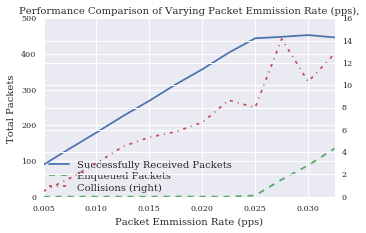

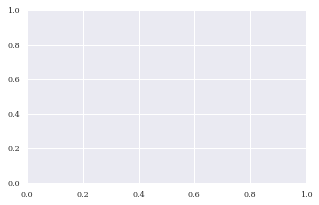

In [20]:
stats = get_emmission_stats(base_df, 100)
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({"text.usetex":False})
var="Packet Emmission Rate (pps)"
rename_labels={"rx_counts":"Successfully Received Packets","enqueued":"Enqueued Packets", "collisions":"Collisions"}
fig=cb.performance_summary_for_var(stats, var=var, rename_labels=rename_labels, hide_annotations=True, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("throughput_performance_static.pdf")
reload(cb)
fig=cb.probability_of_timely_arrival(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("prod_breakdown_static.pdf")
reload(cb)
fig=cb.average_delays_across_variation(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("delay_static.pdf")
reload(cb)
fig=cb.rts_ratio_across_variation(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("rts_static.pdf")

\begin{tabular}{
*{2}{@{\hspace{1em}}r@{\hspace{1em}}}
*{3}{@{\hspace{1em}}p{0.1\textwidth} @{\hspace{1em}}}  }
\toprule
 Separation(m) &  Delay(s) &  Probability of Arrival \\
\midrule
           100 &     71.48 &                    0.99 \\
           200 &     93.55 &                    0.99 \\
           300 &    121.39 &                    0.98 \\
           400 &    289.00 &                    0.96 \\
           500 &    585.38 &                    0.95 \\
           600 &    878.72 &                    0.92 \\
           700 &    742.45 &                    0.92 \\
           800 &   2171.75 &                    0.68 \\
\bottomrule
\end{tabular}



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: 0

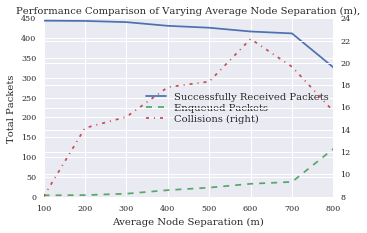

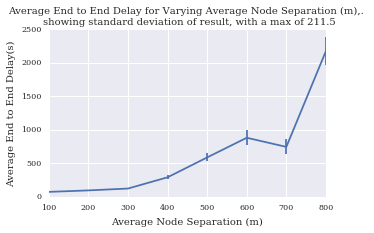

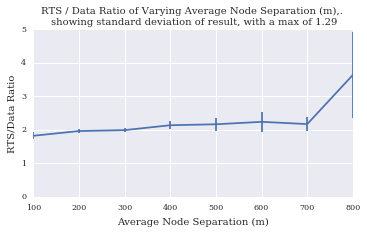

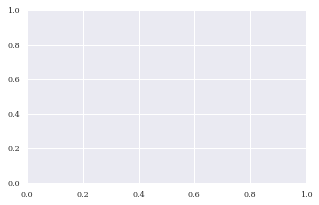

In [25]:
stats = get_separation_stats(base_df,0.025)
var = "Average Node Separation (m)"
rename_labels={"rx_counts":"Successfully Received Packets","enqueued":"Enqueued Packets", "collisions":"Collisions"}
fig=cb.performance_summary_for_var(stats, var=var, rename_labels=rename_labels, hide_annotations=True, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("throughput_performance_range.pdf")
reload(cb)

fig=cb.average_delays_across_variation(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("delay_range.pdf")
reload(cb)


fig=cb.rts_ratio_across_variation(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("rts_range.pdf")
stats['error_rate'] = stats.rx_counts/stats.tx_counts
colmap={'error_rate':'Probability of Arrival','average_rx_delay':'Delay(s)'}
table = stats[['average_rx_delay','error_rate']].groupby(level='var').mean().rename(columns=colmap)
table.index.set_names('Separation(m)',inplace=True)


#ratio = (stats.rts_counts / stats.rx_counts)
#r_mean = ratio.groupby(level='var').mean()
#table['RTS/Data Ratio'] = r_mean

table.reset_index(inplace=True)
#table['Ideal Delivery Time(s)'] = table['Separation(m)']/1400.0 + 9600.0/(10000.0)

tex=table.to_latex(float_format=lambda x:"%1.2f"%x, index=False, column_format="""
*{2}{@{\\hspace{1em}}r@{\\hspace{1em}}}
*{3}{@{\\hspace{1em}}p{0.1\\textwidth} @{\\hspace{1em}}}  """)
os.mkdir('input')
with open('input/range_delay_table.tex','w') as f:
    f.write(tex)
print tex   

fig=cb.probability_of_timely_arrival(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("prod_breakdown_range.pdf")
reload(cb)



# Analses Under Test

* Throughput (bits per second across the network)
* Delay (average recieved delay)
* Throughput Delay Ratio (bps per second of delay) (2D and 3D)
* Normalised Throughput Delay Product (2D and 3D)

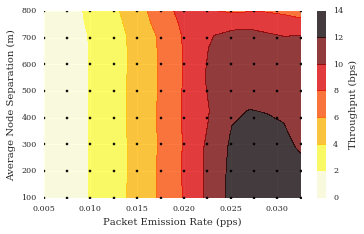

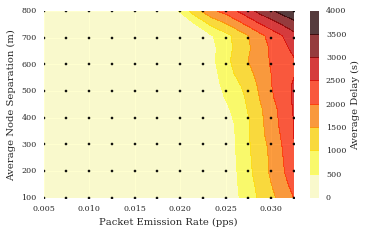

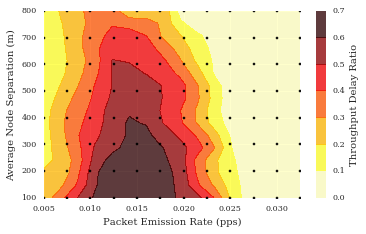

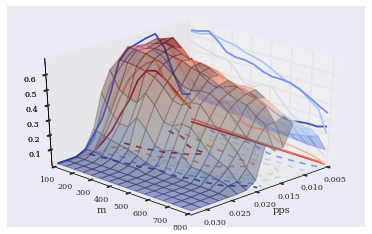

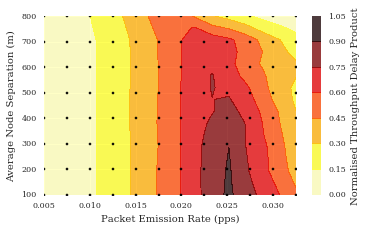

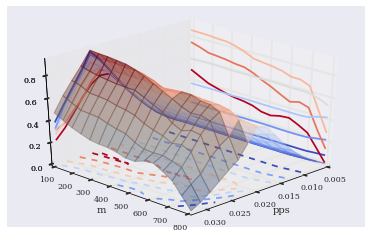

In [22]:
df=base_df.groupby(level=['rate','separation']).mean().reset_index()
import matplotlib.pylab as plt

#rc('text', usetex=False)
norm = lambda df: (df - np.nanmin(df)) / (np.nanmax(df)- np.nanmin(df))
df['average_rx_delay_norm']=1-norm(df.average_rx_delay)
df['throughput_norm']=norm(df.throughput)
df['co_norm'] = df.average_rx_delay_norm*df.throughput_norm
df = df.set_index(['rate','separation']).dropna()
df['tdivdel']=(df.throughput/df.average_rx_delay)
df.reset_index(inplace=True)

xt,yt,zt, Xt, Yt = interpolate_rate_sep(df.dropna(), "throughput")
fig=plot_contour_2d(xt,yt,zt, Xt, Yt, "Throughput (bps)" )
fig.tight_layout(pad=0.1)
fig.savefig("throughput_2d_static.pdf")

xd,yd,zd, Xd, Yd = interpolate_rate_sep(df.dropna(), "average_rx_delay")
fig=plot_contour_2d(xd,yd,zd, Xd, Yd, "Average Delay (s)")
fig.tight_layout(pad=0.1)
fig.savefig("delay_2d_static.pdf")


xd,yd,zd, Xd, Yd = interpolate_rate_sep(df, "tdivdel")
fig=plot_contour_2d(xd,yd,zd, Xd, Yd, "Throughput Delay Ratio")
fig.tight_layout(pad=0.1)
fig.savefig("2d_ratio_static.pdf")

fig=plot_contour_3d(xd,yd,zd, rot=45, labels={'x':'pps', 'y':'m','z':''})
fig.tight_layout(pad=0.1)
fig.savefig("3d_ratio_static.pdf",  transparent=True,facecolor='white')


xd,yd,zd, Xd, Yd = interpolate_rate_sep(df, "co_norm")
fig=plot_contour_2d(xd,yd,zd, Xd, Yd, "Normalised Throughput Delay Product", norm=True)
fig.tight_layout(pad=0.1)
fig.savefig("2d_normed_product_static.pdf")

fig=plot_contour_3d(xd,yd,zd, rot=45, labels={'x':'pps', 'y':'m','z':''})
fig.tight_layout(pad=0.1)
fig.savefig("3d_normed_product_static.pdf",  transparent=True,facecolor='white')


In [ ]:
stats

# TRUST

Reload rate and ranges for trust assessment on selected range and rate... (0.015 and 600)


In [ ]:
import itertools
trust_metrics = np.asarray("ADelay,ALength,ARXP,ATXP,RXThroughput,PLR,TXThroughput".split(','))
exclude = "ATXP,ALength".split(',')
trust_combinations=[]
map(trust_combinations.extend,
    np.asarray([itertools.combinations(trust_metrics,i) 
                for i in range(3,len(trust_metrics))])
    )
trust_combinations=np.asarray(filter(lambda x: all(map(lambda m: m not in exclude,x)),trust_combinations))
#print trust_combinations
trust_metric_selections=np.asarray([map(lambda m: float(m in trust_combination),trust_metrics) for trust_combination in trust_combinations])
trust_metric_weights=map(lambda s: s/sum(s),trust_metric_selections)
#map(lambda w:trust_metrics[np.where(w>0)].tolist(),trust_metric_weights)

base_rate = 0.015
base_separation = 600

trustsd={}
for store_path in rate_and_ranges:
    with pd.get_store(store_path) as s:
        trust = s.get('trust')
        # Reset Range for separation in m
        trust.index = trust.index.set_levels([
             np.int32((np.asarray(trust.index.levels[0].astype(np.float64))*100)),  # Var
             trust.index.levels[1].astype(np.int32) # Run
            ]+(trust.index.levels[2:])
        )
        trustsd[app_rate_from_path(store_path)] = trust.copy()
df=pd.concat(trustsd.values(), keys=trustsd.keys(), names = ['rate','separation']+trust.index.names[1:])
trust_df = df.reset_index().sort(['rate','separation']).set_index(['rate','separation','run','observer','t','target'])
trust

In [ ]:
base_df.xs(0.015,level="rate")

In [ ]:
pylab.rcParams['figure.figsize'] = 16, 12  

_=(stats.unstack(level='node').throughput/3600).groupby(level='var').boxplot()

In [ ]:
from __future__ import division 
choices = zip(range(5),np.random.random_integers(1000,10000,5))
names, distances = zip(*choices)
inv_distances = 1.0/np.array(distances)
norm_distances = inv_distances/sum(inv_distances)
norm_distances, choices

In [ ]:
sns.distplot([np.random.choice(names, p=norm_distances) for _ in range(100)])

In [ ]:
for v,g in rx.reset_index().set_index('received').groupby(['var','run','node']):
    g.index=pd.to_datetime(g.index)
    #print g.count(axis=0)

In [ ]:
stats